In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from db.database import Database
from db.models import Blueprint
from util.lang_identification import identify_language_yaml
from bs4 import BeautifulSoup
import re
from util.text_manipulation import remove_html, tfidf_preprocessing

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
database_url = f"sqlite:///home_assistant_blueprints.sqlite"
topics_df = pd.read_sql("topics", database_url, columns=["id", "topic_id", "title", "topic_url", "tags"])
posts_df = pd.read_sql("posts", database_url, columns=["id", "post_id", "topic_id", "score", "cooked"])
blueprints_df = pd.read_sql("blueprints", database_url, columns=["id", "blueprint_code", "post_id", "extracted_keywords", "topic_keywords"])
blueprints_df.head()

,id,blueprint_code,post_id,extracted_keywords,topic_keywords
0,1,blueprint:\n name: Nag prompt blueprint\n de...,1220860,{'input__input_boolean': 2},"{'android': 0.04282333988128355, 'user': 0.042..."
1,2,blueprint:\n name: Inovelli \n description: ...,1220678,{},"{'inovelli': 0.027025502281732554, 'create': 0..."
2,3,blueprint:\n name: deCONZ - IKEA five button ...,1223455,{'input__deconz': 1},"{'short': 0.01649244354775234, 'long': 0.01649..."
3,4,blueprint:\n name: Heat for certain time\n d...,1223628,"{'input__input_datetime': 1, 'input__climate': 2}","{'set': 0.055741499059047184, 'temperature': 0..."
4,5,blueprint:\n name: Light Allowance\n descrip...,1224871,"{'input__light': 1, 'output__light': 1}","{'time': 0.11369206228658875, 'light': 0.13453..."


In [3]:
lang_codes = []
for index, row in blueprints_df.iterrows():
    code = row["blueprint_code"]
    lang_code = identify_language_yaml(code)
    lang_codes.append(lang_code)
    
blueprints_df["lang_code"] = lang_codes
blueprints_df.head()

,id,blueprint_code,post_id,extracted_keywords,topic_keywords,lang_code
0,1,blueprint:\n name: Nag prompt blueprint\n de...,1220860,{'input__input_boolean': 2},"{'android': 0.04282333988128355, 'user': 0.042...",en
1,2,blueprint:\n name: Inovelli \n description: ...,1220678,{},"{'inovelli': 0.027025502281732554, 'create': 0...",en
2,3,blueprint:\n name: deCONZ - IKEA five button ...,1223455,{'input__deconz': 1},"{'short': 0.01649244354775234, 'long': 0.01649...",en
3,4,blueprint:\n name: Heat for certain time\n d...,1223628,"{'input__input_datetime': 1, 'input__climate': 2}","{'set': 0.055741499059047184, 'temperature': 0...",en
4,5,blueprint:\n name: Light Allowance\n descrip...,1224871,"{'input__light': 1, 'output__light': 1}","{'time': 0.11369206228658875, 'light': 0.13453...",en


In [4]:
before_count = blueprints_df.__len__()
blueprints_df = blueprints_df[blueprints_df["lang_code"] == "en"]
after_count = blueprints_df.__len__()
before_count, after_count

(2228, 2191)

In [5]:
_topic_post_df = topics_df.merge(posts_df, left_on="topic_id", right_on="topic_id")
_topic_post_bps_df = _topic_post_df.merge(blueprints_df, left_on="post_id", right_on="post_id")
_topic_post_bps_df.head()

,id_x,topic_id,title,topic_url,tags,id_y,post_id,score,cooked,id,blueprint_code,extracted_keywords,topic_keywords,lang_code
0,2,255041,Nag prompt Blueprint (Android Notification),https://community.home-assistant.io//t/nag-pro...,[],3,1220860,703,<p>This blueprints creates configurable nag no...,1,blueprint:\n name: Nag prompt blueprint\n de...,{'input__input_boolean': 2},"{'android': 0.04282333988128355, 'user': 0.042...",en
1,4,254999,Inovelli LZW36 Fan/Dimmer Scenes,https://community.home-assistant.io//t/inovell...,"[""blueprint""]",5,1220678,1014,<p>This blueprint allows you to easily create ...,2,blueprint:\n name: Inovelli \n description: ...,{},"{'inovelli': 0.027025502281732554, 'create': 0...",en
2,5,255699,deCONZ - IKEA five button remote,https://community.home-assistant.io//t/deconz-...,"[""switch"", ""blueprint"", ""deconz""]",11,1223455,976,"<p>This is a mix of <a href=""https://community...",3,blueprint:\n name: deCONZ - IKEA five button ...,{'input__deconz': 1},"{'short': 0.01649244354775234, 'long': 0.01649...",en
3,6,255742,Set heating temperature to a configurable valu...,https://community.home-assistant.io//t/set-hea...,[],12,1223628,482,"<p>This is a blueprint, that allows to set the...",4,blueprint:\n name: Heat for certain time\n d...,"{'input__input_datetime': 1, 'input__climate': 2}","{'set': 0.055741499059047184, 'temperature': 0...",en
4,7,256045,Light Allowance,https://community.home-assistant.io//t/light-a...,[],13,1224871,136,<p>This blueprint will turn a light off after ...,5,blueprint:\n name: Light Allowance\n descrip...,"{'input__light': 1, 'output__light': 1}","{'time': 0.11369206228658875, 'light': 0.13453...",en


In [6]:
from util.structural_diff import compare_multiple_bps
import tqdm
db = Database()
unique_topic_ids = _topic_post_bps_df["topic_id"].unique()
threshold = 0.8
tbr = []
for topic_id in tqdm.tqdm(unique_topic_ids, desc="Analyzing topics for similar blueprints"):
    topic_subset = _topic_post_bps_df[_topic_post_bps_df["topic_id"] == topic_id]
    topic_subset_bps = topic_subset["blueprint_code"].tolist()
    if len(topic_subset_bps) >= 2:
        ids = topic_subset["id"].tolist()
        bps = db.get_blueprints_by_ids(ids)
        scores = compare_multiple_bps(bps)
        sim_groups = []
        
        for bp1, bp2, score in scores:
            if score > threshold:
                sim_groups.append((bp1, bp2))
                
        if sim_groups.__len__() > 0:
            flat_sim_groups = set(bp for pair in sim_groups for bp in pair)
            for bp in flat_sim_groups:
                if bp != list(flat_sim_groups)[-1]:
                    bp_id = bp.id
                    tbr.append(bp_id)

_topic_post_bps_df = _topic_post_bps_df[~_topic_post_bps_df["id"].isin(tbr)]
_topic_post_bps_df.head()

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 241.18it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 1135.74it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 1001.74it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 1999.67it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 1976.11it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 1000.79it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 1272.35it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 666.93it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 949.69it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 1000.67it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 1990.18it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 2000.62it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]

Loading blueprints: 100%|██████████| 2/2 [00:00<00:00, 794.15it/s]

Loading blueprints: 100%|██████████| 2

,id_x,topic_id,title,topic_url,tags,id_y,post_id,score,cooked,id,blueprint_code,extracted_keywords,topic_keywords,lang_code
0,2,255041,Nag prompt Blueprint (Android Notification),https://community.home-assistant.io//t/nag-pro...,[],3,1220860,703,<p>This blueprints creates configurable nag no...,1,blueprint:\n name: Nag prompt blueprint\n de...,{'input__input_boolean': 2},"{'android': 0.04282333988128355, 'user': 0.042...",en
1,4,254999,Inovelli LZW36 Fan/Dimmer Scenes,https://community.home-assistant.io//t/inovell...,"[""blueprint""]",5,1220678,1014,<p>This blueprint allows you to easily create ...,2,blueprint:\n name: Inovelli \n description: ...,{},"{'inovelli': 0.027025502281732554, 'create': 0...",en
2,5,255699,deCONZ - IKEA five button remote,https://community.home-assistant.io//t/deconz-...,"[""switch"", ""blueprint"", ""deconz""]",11,1223455,976,"<p>This is a mix of <a href=""https://community...",3,blueprint:\n name: deCONZ - IKEA five button ...,{'input__deconz': 1},"{'short': 0.01649244354775234, 'long': 0.01649...",en
3,6,255742,Set heating temperature to a configurable valu...,https://community.home-assistant.io//t/set-hea...,[],12,1223628,482,"<p>This is a blueprint, that allows to set the...",4,blueprint:\n name: Heat for certain time\n d...,"{'input__input_datetime': 1, 'input__climate': 2}","{'set': 0.055741499059047184, 'temperature': 0...",en
4,7,256045,Light Allowance,https://community.home-assistant.io//t/light-a...,[],13,1224871,136,<p>This blueprint will turn a light off after ...,5,blueprint:\n name: Light Allowance\n descrip...,"{'input__light': 1, 'output__light': 1}","{'time': 0.11369206228658875, 'light': 0.13453...",en


In [7]:
_topic_post_bps_df.__len__()

1786

In [8]:
groups = {}
for topic in _topic_post_bps_df["topic_id"].unique():
    if _topic_post_bps_df[_topic_post_bps_df["topic_id"] == topic].__len__() > 1:
        groups[topic] = _topic_post_bps_df[_topic_post_bps_df["topic_id"] == topic]["blueprint_code"].tolist()
groups.keys()

dict_keys(['259767', '256311', '257141', '286465', '280125', '255456', '365041', '255878', '385439', '283973', '264183', '274711', '257617', '278447', '325923', '266178', '384292', '255120', '293469', '333950', '360129', '260772', '280639', '359802', '294721', '301019', '387748', '377149', '255880', '303161', '264599', '365496', '270813', '329408', '278457', '272106', '269701', '395834', '341053', '298080', '505809', '441117', '261280', '261885', '256138', '259363', '524435', '280883', '259010', '476095', '350490', '391475', '256630', '255999', '326917', '314233', '255733', '261814', '311091', '381800', '430415', '410062', '491657', '390055', '289816', '281459', '355314', '447543', '449117', '265010', '341354', '366348', '402565', '280891', '261936', '393164', '296528', '277977', '367102', '314943', '256409', '388683', '455427', '257953', '297287', '333870', '263006', '256542', '421215', '284720', '273031', '258904', '275751', '283190', '290561', '256212', '680380', '613989', '337274',

In [9]:
from util.text_manipulation import parse_yaml
for bp_code in groups.get("259767"):
    print(parse_yaml(bp_code))

{'blueprint': {'name': 'Periodic lights', 'description': "Dim and adjust color temperature of lights progressively throughout the evening (RGB bulbs probably won't change temperature). This is indexed to the midpoint between sunset and sunrise and fit to a sin function, so the midpoint will be minimum brightness and midpoint +12hr will be maximum brightness. The midpoint can be offset by a fixed amount if lights are too dim or bright at the desired time.", 'domain': 'automation', 'source_url': 'https://gist.github.com/haberda/f17694969a6de15d75267667b7c955ac', 'input': {'light': {'name': 'Light(s)', 'description': 'The light(s) to control', 'selector': {'entity': {'multiple': True, 'domain': 'light'}}}, 'min_brightness': {'name': 'Minimum Brightness', 'description': 'Minimum brightness of the light(s)', 'default': 1, 'selector': {'number': {'min': 0.0, 'max': 100.0, 'mode': 'slider', 'step': 1.0, 'unit_of_measurement': '%'}}}, 'max_brightness': {'name': 'Maximum Brightness', 'descripti

In [10]:
_topic_post_df["topic_id"].unique().__len__(), _topic_post_bps_df["topic_id"].unique().__len__()

(1657, 1183)

In [11]:
_topic_post_df = _topic_post_df[_topic_post_df['topic_id'].isin(_topic_post_bps_df['topic_id'])]
_topic_post_df["topic_id"].unique().__len__()

1183

In [12]:
corpus = []
for topic in tqdm.tqdm(_topic_post_df["topic_id"].unique(), desc="Preprocessing and grouping by topic"):
    topic_subset = _topic_post_df[_topic_post_df["topic_id"] == topic]
    texts = topic_subset["cooked"].tolist()
    combined_text = " ".join([tfidf_preprocessing(text) for text in texts])
    corpus.append(combined_text)
corpus.__len__()

Preprocessing and grouping by topic: 100%|██████████| 1183/1183 [11:41<00:00,  1.69it/s]


1183

In [13]:
tfidf = TfidfVectorizer()
res = tfidf.fit_transform(corpus)
res.shape

(1183, 35222)

In [18]:
terms = tfidf.get_feature_names_out()
import numpy as np
def extract_top_n_keywords(row, features, top_n=10):
    row_array = row.toarray().flatten()
    top_n_indices = np.argsort(row_array)[-top_n:][::-1]
    top_n_terms = [features[i] for i in top_n_indices]
    top_n_scores = [row_array[i] for i in top_n_indices]
    return list(zip(top_n_terms, top_n_scores))
top_keywords_per_topic = []
for i in range(res.shape[0]):
    row = res[i]
    top_keywords = extract_top_n_keywords(row, terms, top_n=2)
    top_keywords_per_topic.append(top_keywords)
top_keywords_per_topic

[[('ack', 0.25629519733144945), ('remainder', 0.25629519733144945)],
 [('inovelli', 0.4480795105528542), ('statically', 0.23417190831099324)],
 [('button', 0.4609686549575892), ('short', 0.4427008860062375)],
 [('hhmmss', 0.3432881316115931), ('school', 0.32657971710228617)],
 [('allotted', 0.7606324410218014), ('preset', 0.5478257198513283)],
 [('toyed', 0.4810111009315472), ('numerical', 0.36995238625735877)],
 [('weekday', 0.47772042373156437), ('thermostat', 0.38375414258729884)],
 [('crashed', 0.29571286209622905), ('additional', 0.22061307988364076)],
 [('make', 0.21540276004320671), ('expect', 0.20932434182814735)],
 [('player', 0.35328944630772036), ('medium', 0.3329263421138743)],
 [('telegram', 0.5727260239931724), ('preconfig', 0.49516803145463106)],
 [('music', 0.38117910045649783), ('playing', 0.3107940704998986)],
 [('volume', 0.5307827498978869), ('1642022', 0.2321585673246451)],
 [('hanno', 0.5762373947278716), ('scene_value_id', 0.4784669307904926)],
 [('_ids', 0.32403

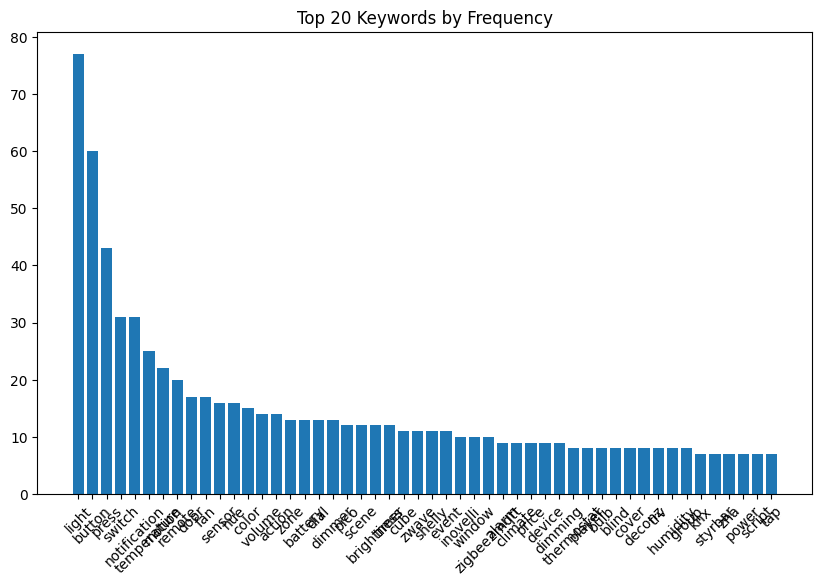

In [22]:
import matplotlib.pyplot as plt
from collections import Counter
all_keywords = [term for sublist in top_keywords_per_topic for term, score in sublist]
keyword_counts = Counter(all_keywords)
plt.figure(figsize=(10, 6))
most_common_keywords = keyword_counts.most_common(50)
keywords, counts = zip(*most_common_keywords)
plt.bar(keywords, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Keywords by Frequency")
plt.show()